In [ ]:
# Version for 1971.08 - 2024.12 without IV and RV
# ======== COMMON CONFIG (run once) ==========================================
import os, sys, re, warnings, argparse, pandas as pd
warnings.filterwarnings("ignore")

from rolling_framework import Machine           # <-- 프로젝트의 핵심 API

# ---- 유틸 함수 --------------------------------------------------------------
def _load_csv(path, name):
    try:  return pd.read_csv(path, index_col="Time")
    except FileNotFoundError as e:
        sys.exit(f"[ERROR] missing {name} → {e.filename}")

def _align_time(*dfs):
    idx=None
    for d in dfs: idx = d.index if idx is None else idx.intersection(d.index)
    return [d.loc[idx].sort_index() for d in dfs]

def _direct_pairs(slope_cols, y_cols):
    mk = lambda s: re.search(r"(\d+)", s).group(1) if re.search(r"(\d+)", s) else None
    y_map = {mk(c): c for c in y_cols}
    return [(sc, y_map[mk(sc)]) for sc in slope_cols if mk(sc) in y_map]

# ---- Edit This ------------------------------------------------------
DATA_DIR      = "data/"
Y_FILE        = os.path.join(DATA_DIR, "exrets.csv")
SLOPE_FILE    = os.path.join(DATA_DIR, "slope.csv")
YL_FILE       = os.path.join(DATA_DIR, "yl_all.csv")
MACRO_FILE    = os.path.join(DATA_DIR, "MacroFactors.csv")
IV_FILE =    os.path.join(DATA_DIR, "imp_vol.csv")
LSC_FILE = os.path.join(DATA_DIR, "lsc.csv")
RV_FILE = os.path.join(DATA_DIR, "real_vol.csv")
FWD_FILE = os.path.join(DATA_DIR, "fwds.csv")
CP_FILE = os.path.join(DATA_DIR, "cp.csv")

OUT_DIR       = "./output";  os.makedirs(OUT_DIR, exist_ok=True)

# Horizon 
BURN_START, BURN_END   = "197108", "199009"
PERIOD_START, PERIOD_END = "197108", "202312"
HORIZON = 12                           # months ahead

MATURITIES = ["xr_2","xr_3","xr_5","xr_7","xr_10"]

y     = _load_csv(Y_FILE,   "exrets")
slope = _load_csv(SLOPE_FILE, "slope") # This slope includes all maturities (i.e 2-1, 3-1, ..., 10-1)
lsc = _load_csv(LSC_FILE, "lsc")
yl    = _load_csv(YL_FILE,   "yl_all")
macro = _load_csv(MACRO_FILE,"MacroFactors")
# iv = _load_csv(IV_FILE, "imp_vol")
# rv = _load_csv(RV_FILE, "real_vol")
fwd = _load_csv(FWD_FILE, "fwd")
cp = _load_csv(CP_FILE, "cp")

# --------------------------------------------------------------------------

    # 타깃 열 필터
y_cols = [c for c in MATURITIES if c in y.columns]
if not y_cols: sys.exit("[ERROR] MATURITIES not in exrets")
y = y[y_cols]

# 시간축 맞추기
y, slope, yl, macro, lsc, fwd, cp = _align_time(y, slope, yl, macro, lsc, fwd, cp)

In [9]:
# ────────────────────────────
# Random-Forest
# ────────────────────────────
param_grid_rf = {
    "model__estimator__n_estimators":      [300],
    "model__estimator__max_depth":         [2, 8],
    "model__estimator__min_samples_split": [2, 4],
    "model__estimator__min_samples_leaf":  [1, 2, 4],
    "model__estimator__max_features":      [0.25, 0.5,1],
}

# ────────────────────────────
# Extra-Trees
# ────────────────────────────
param_grid_et = {
    "model__estimator__n_estimators":      [300],
    "model__estimator__max_depth":         [2, 8],
    "model__estimator__min_samples_split": [2, 4],
    "model__estimator__min_samples_leaf":  [1, 2, 4],
    "model__estimator__max_features":      [0.25, 0.5, 1],
}

# ────────────────────────────
# XGBoost  (XGBRegressor 사용 가정)
# ────────────────────────────
param_grid_xgb = {
    "model__estimator__n_estimators":  [300],
    "model__estimator__max_depth":     [2, 4],
    "model__estimator__learning_rate": [0.01],
    "model__estimator__subsample":     [0.7, 0.5],
    "model__estimator__reg_lambda":    [0.1, 1.0],
}

param_grid_lasso = {'reg__alpha': [1,10,100]}    
param_grid_ridge      = {'reg__alpha': [1,10,100]}
param_grid_elasticnet = {
    'reg__alpha':   [0.01, 0.1, 1, 10],
    'reg__l1_ratio':[0.1, 0.3, 0.5],
}

## Modulate Predictor Variable

In [10]:
import numpy as np
slope_10 = lsc[['slope']] # 10yr slope
X1 = pd.concat([macro], axis=1)

param_grid_ridge = {'reg__alpha': np.logspace(-3,2,30)}    

In [11]:
m1 = Machine(X1, y, 'Penalized', option="ridge", params_grid=param_grid_ridge,
             burn_in_start=BURN_START, burn_in_end=BURN_END,
             period=[PERIOD_START, PERIOD_END], forecast_horizon=HORIZON)
m1.training()
print(m1.R2OOS())


Penalized rolling:   0%|          | 0/400 [00:00<?, ?it/s]

Penalized rolling: 100%|██████████| 400/400 [00:34<00:00, 11.57it/s]


xr_2    -0.190642
xr_3    -0.085277
xr_5    -0.017861
xr_7     0.013692
xr_10    0.083632
dtype: float64


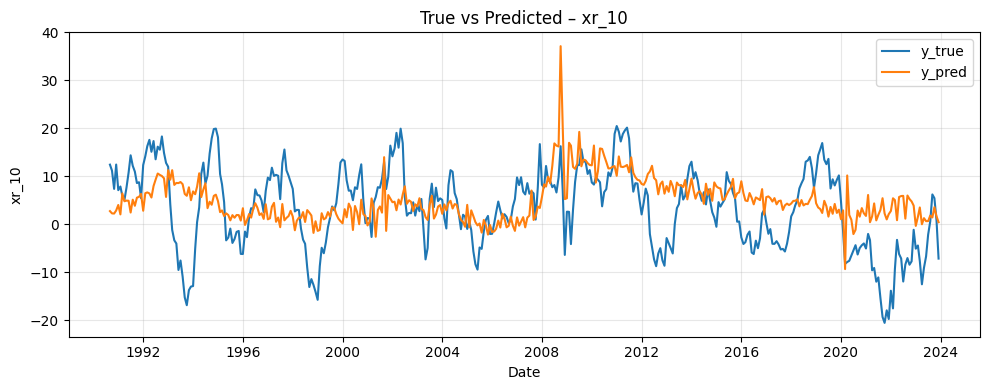

In [6]:
m1.compare_plot('xr_10')

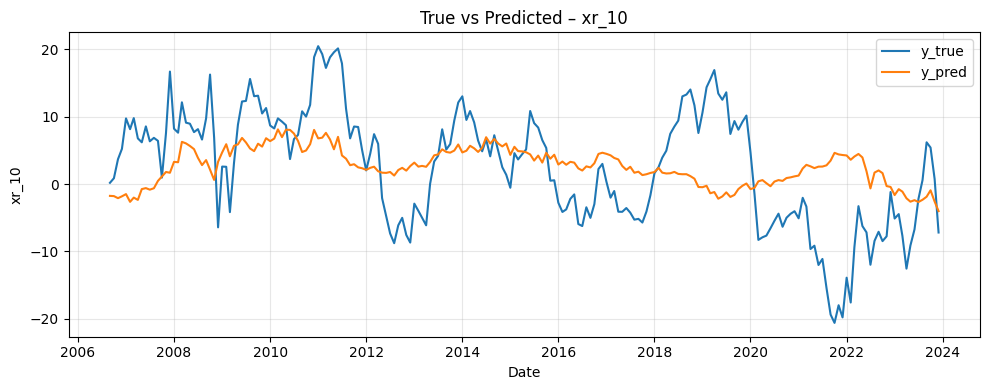

In [62]:
m1.compare_plot('xr_10')

In [38]:
import numpy as np


param_grid_lasso = {'reg__alpha': [0]}    
param_grid_ridge = {'reg__alpha': np.logspace(-3,2,30)}    

In [12]:
import pandas as pd
from itertools import combinations

def make_X1_sets(iv: pd.DataFrame, rv: pd.DataFrame, dropna: bool = True):
    """
    Generate all X1 candidates following the 'same-position pairing' rule.
    - Adds 'IV_only' = all 3 IV columns
    - For each non-empty subset of positions S among [1, 2, 3], creates IVS+RVS by concatenating
      iv[S] and rv[S] (column positions are 1-based in the name only).

    Parameters
    ----------
    iv, rv : DataFrame
        DataFrames with the same monthly index 'Time'. Columns ordered as given.
    dropna : bool
        If True, drop rows with any NaNs after concatenation.

    Returns
    -------
    dict[str, DataFrame]
        Mapping from name -> X1 DataFrame
    """
    # 1) Align indices (inner join on Time)
    common_idx = iv.index.intersection(rv.index)
    iv_aln = iv.loc[common_idx]
    rv_aln = rv.loc[common_idx]

    out = {}

    # Case 1: IV only (all three IV columns)
    X_iv = iv_aln.copy()
    out["IV_only"] = X_iv.dropna() if dropna else X_iv

    # 2) All non-empty subsets of positions among the first p columns in common
    p = min(iv_aln.shape[1], rv_aln.shape[1])  # usually 3
    positions = list(range(p))                 # 0-based

    def pos_label(pos_list):
        # Convert 0-based positions to a compact 1-based label string: [0,1] -> "12"
        return "".join(str(i + 1) for i in pos_list)

    for r in range(1, p + 1):                  # subset size: 1, 2, ..., p
        for pos in combinations(positions, r):
            cols = list(pos)
            X = pd.concat([iv_aln.iloc[:, cols], rv_aln.iloc[:, cols]], axis=1)
            name = f"IV{pos_label(cols)}+RV{pos_label(cols)}"
            out[name] = X.dropna() if dropna else X

    return out

# ─────────────────────────── USAGE EXAMPLE ───────────────────────────
# Assume iv, rv, y, param_grid_ridge, and scheduling constants are already defined.

X_sets = make_X1_sets(iv, dropna=True)

results = {}
for name, X1 in X_sets.items():
    m1 = Machine(
        X1, y, 'Penalized', option="ridge", params_grid=param_grid_ridge,
        burn_in_start=BURN_START, burn_in_end=BURN_END,
        period=[PERIOD_START, PERIOD_END], forecast_horizon=HORIZON
    )
    m1.training()
    results[name] = m1.R2OOS()

# Quick view
for k, v in results.items():
    print(k, v)

NameError: name 'iv' is not defined

In [55]:
m1 = Machine(X1, y, "Penalized", option="ridge", params_grid=param_grid_ridge,
             burn_in_start=BURN_START, burn_in_end=BURN_END,
             period=[PERIOD_START, PERIOD_END], forecast_horizon=HORIZON)
m1.training()
print(m1.R2OOS())

Penalized rolling: 100%|██████████| 208/208 [00:03<00:00, 58.15it/s]

xr_2    -1.150495
xr_3    -1.319008
xr_5    -1.310705
xr_7    -1.115745
xr_10   -0.808543
dtype: float64


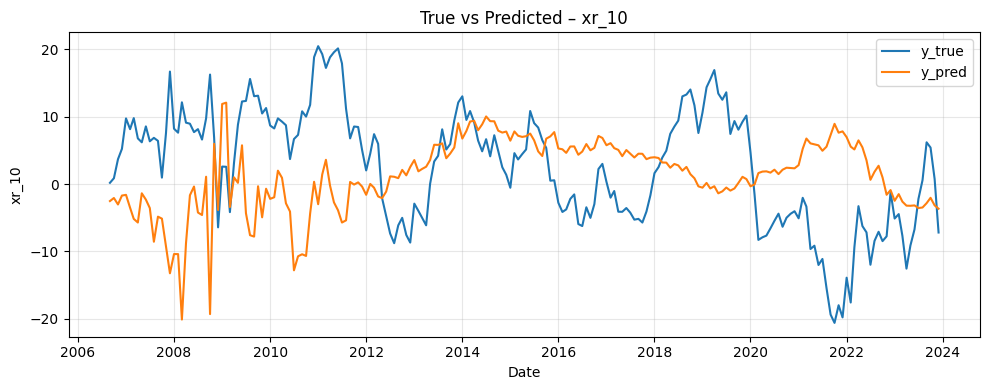

In [56]:
m1.compare_plot("xr_10")

In [ ]:
m = Machine(
    SL, y,
    model_type="OLS",
    forecast_horizon=12,
)
m.training()
print(m.R2OOS())
print(m.RSZ_Signif())
print(m.mse_oos(normalize = 'std'))
m.compare_plot("xr_10")